# Run A Mixed Effects Model

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a predictors relationship to the predictee is different between two groups. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/metadata/master_list_proper_subjects.xlsx'

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/retrospective_cohorts_figure/mixed_effect_analyses'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet='master_list_proper_subjects')
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [234]:
drop_list = ['Age_Disease_and_Cohort', 'Subiculum_Group_By_Inflection_Point']

In [235]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

,subject,Age,Normalized_Percent_Cognitive_Improvement,Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group,Z_Scored_Percent_Cognitive_Improvement,Percent_Cognitive_Improvement,Z_Scored_Subiculum_T_By_Origin_Group_,Z_Scored_Subiculum_Connectivity_T,Subiculum_Connectivity_T,Amnesia_Lesion_T_Map,...,Z_Scored_Cognitive_Baseline,Z_Scored_Cognitive_Baseline__Lower_is_Better_,Min_Max_Normalized_Baseline,MinMaxNormBaseline_Higher_is_Better,ROI_to_Alz_Max,ROI_to_PD_Max,Standardzied_AD_Max,Standardized_PD_Max,interaction,test
0,101,62.0,-0.392857,0.314066,0.314066,-21.428571,-1.282630,-1.282630,56.864683,0.447264,...,1.518764,-1.518764,0.72,0.28,12.222658,14.493929,-1.714513,-1.227368,3525.610316,0
1,102,77.0,-0.666667,0.013999,0.013999,-36.363636,-1.760917,-1.760917,52.970984,0.436157,...,0.465551,-0.465551,0.48,0.52,14.020048,15.257338,-1.155843,-1.022243,4078.765733,1
2,103,76.0,-1.447368,-0.841572,-0.841572,-78.947368,-0.595369,-0.595369,62.459631,0.497749,...,-0.061056,0.061056,0.36,0.64,15.118727,17.376384,-0.814348,-0.452865,4746.931951,2
3,104,65.0,-2.372549,-1.855477,-1.855477,-129.411765,-0.945206,-0.945206,59.611631,0.432617,...,-0.412127,0.412127,0.28,0.72,13.112424,15.287916,-1.437954,-1.014027,3874.756046,3
4,105,50.0,-0.192982,0.533109,0.533109,-10.526316,-1.151973,-1.151973,57.928350,0.193389,...,-0.061056,0.061056,0.36,0.64,15.086568,12.951426,-0.824344,-1.641831,2896.417494,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,86,57.0,NaN,0.598787,-0.099428,0.000000,-0.087220,-0.621000,22.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1265.400000,160
161,87,65.0,NaN,0.598787,-0.099428,0.000000,0.598397,0.173000,27.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1755.000000,161
162,88,65.0,NaN,5.854050,2.637141,15.384615,0.269872,-0.207000,24.700000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1605.500000,162
163,89,67.0,NaN,0.598787,-0.099428,0.000000,-0.158639,-0.694000,21.700000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1453.900000,163


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [ ]:
data_df.columns

Set the parameters for dropping rows

In [ ]:
column = 'Cohort'  # The column you'd like to evaluate
condition = 'equal'  # The condition to check ('equal', 'above', 'below')
value = 3  # The value to compare against

In [ ]:
data_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Age']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

# 02 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [162]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Age_Group', 'Age_And_Disease',
       'Age_Disease_and_Cohort', 'Subiculum_Group_By_Z_Score_Sign',
       'Subiculum_Group_By_Infl

In [163]:
formula = "Z_Scored_Percent_Cognitive_Improvement ~ C(Age_Group)*C(Subiculum_Group_By_Inflection_Point)"

# 03 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [164]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df)
design_matrix

,Intercept,C(Age_Group)[T.young],C(Subiculum_Group_By_Inflection_Point)[T.low],C(Age_Group)[T.young]:C(Subiculum_Group_By_Inflection_Point)[T.low]
0,1.0,1.0,1.0,1.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
160,1.0,1.0,1.0,1.0
161,1.0,0.0,0.0,0.0
162,1.0,0.0,0.0,0.0
163,1.0,0.0,1.0,0.0


# 04 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [165]:
outcome_matrix

,Z_Scored_Percent_Cognitive_Improvement
0,0.314066
1,0.013999
2,-0.841572
3,-1.855477
4,0.533109
...,...
160,-0.099428
161,-0.099428
162,2.637141
163,-0.099428


# 05 - Define your Groups to Assess Between

In [166]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Age_Group', 'Age_And_Disease',
       'Age_Disease_and_Cohort', 'Subiculum_Group_By_Z_Score_Sign',
       'Subiculum_Group_By_Infl

In [167]:
groups = 'City'

# 06 - Are You Allowing Random Intercepts?
- Set this to False if you do not want to do this. However, it is generally best to define a random intercept in a mixed effects model.

In [168]:
random_intercepts = True

# 07 - What Columns Would You Like to Perform Random Slopes On?
- Set this to None if you would not like to set random slopes.
- Set to a list of column names that you would like to test.

In [169]:
design_matrix.columns

Index(['Intercept', 'C(Age_Group)[T.young]',
       'C(Subiculum_Group_By_Inflection_Point)[T.low]',
       'C(Age_Group)[T.young]:C(Subiculum_Group_By_Inflection_Point)[T.low]'],
      dtype='object')

In [170]:
random_slopes = ['C(Age_Group)[T.young]:C(Subiculum_Group_By_Inflection_Point)[T.low]']

# 07 - Run The Model

In [171]:
try:
    print('Running original mixed effects model.')
    result = cal_palm.run_mixed_effects_model(y=outcome_matrix, X=design_matrix, groups=groups, random_intercepts=random_intercepts, random_slopes=random_slopes)
except:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    try:
        print(f'Excepting and running with: \n - random slopes for variable: {random_slopes} \n - random intercepts for group: {groups}')
        mixed_lm = smf.mixedlm(formula, data_df, groups=groups, re_formula = f"~{random_slopes}")
        result = mixed_lm.fit(method=["lbfgs"])
    except:
        print(f'Excepting and running with: \n - no random slopes \n - random intercepts for group: {groups}')
        mixed_lm = smf.mixedlm(formula, data_df, groups=groups)
        result = mixed_lm.fit()

Running original mixed effects model.
Excepting and running with: 
 - random slopes for variable: ['C(Age_Group)[T.young]:C(Subiculum_Group_By_Inflection_Point)[T.low]'] 
 - random intercepts for group: City
Excepting and running with: 
 - no random slopes 
 - random intercepts for group: City


/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/nimlab_p

**Manual Mixed Effects**

In [260]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Age_Group', 'Age_And_Disease',
       'Age_Disease_and_Cohort', 'Subiculum_Group_By_Z_Score_Sign',
       'Subiculum_Group_By_Infl

Mixed Effects Formula Structure
- outcome ~ regressor_1 + regressor_2 + (1 + regressor_2 | group)
    - the ( | ) statement is the random effects statement. 
    - 1 (random intercept) or 0 (fixed intercept) indicates the random intercept
    - regressor_2 indicates the random slope for the regressor of interest. 
    - group is simply the group. So, this random effect is calculated | (per) group. 

Statsmodels Command Structure
- formula is the string: "outcome ~ regressor_1 + regressor_2" from outcome ~ regressor_1 + regressor_2 + (1 + regressor_2 | group)
- random intercepts is defined as "groups=group" from  outcome ~ regressor_1 + regressor_2 + (1 + regressor_2 | group)
- random slopes is defined as "re_formula=~regressor_2"  outcome ~ regressor_1 + regressor_2 + (1 + regressor_2 | group)

In [271]:
backup_formula = f"Z_Scored_Percent_Cognitive_Improvement ~ Age*Subiculum_Connectivity_T"

In [272]:
groups='City'

Set to None if you would like to remove random slopes

In [281]:
re_formula=None

In [282]:
mixed_lm = smf.mixedlm(backup_formula, data_df, groups=data_df[groups], re_formula=re_formula)
result = mixed_lm.fit()

/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/stats

# 08 - View Results
- If "converged: No" reported in below results, be extremely cautious in interpretation. 
    - I would suggest simplifying until you achieve convergence. 

In [283]:
print(result.summary())

                       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Z_Scored_Percent_Cognitive_Improvement
No. Observations: 148     Method:             REML                                  
No. Groups:       4       Scale:              0.9562                                
Min. group size:  17      Log-Likelihood:     inf                                   
Max. group size:  59      Converged:          Yes                                   
Mean group size:  37.0                                                              
--------------------------------------------------------------------------------------
                                  Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------------------
Intercept                          0.000                                              
Age                               -0.038      0.021   -1.804   0.071   -0.079    

/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


# plot Random Effects

In [ ]:
for k, v in result.random_effects.items():
    print(k)
    print(v)

Select one of the random effects above to plot. 

In [ ]:
effect_to_plot='Age:Z_Scored_Subiculum_Connectivity_T'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an empty list to store interaction effects
interaction_effects = []

# Loop through the groups and extract interaction effects
for group, effects in result.random_effects.items():
    interaction_effect = effects[effect_to_plot]
    interaction_effects.append(interaction_effect)

# Create a boxplot with groups side-by-side
plt.figure(figsize=(10, 6))
sns.boxplot(x=list(result.random_effects.keys()), y=interaction_effects)

plt.xlabel('Group')
plt.ylabel(f'Random Effect: {effect_to_plot}')
plt.title('Distribution of Random Effects by Group')

plt.xticks(rotation=45)
plt.show()



More

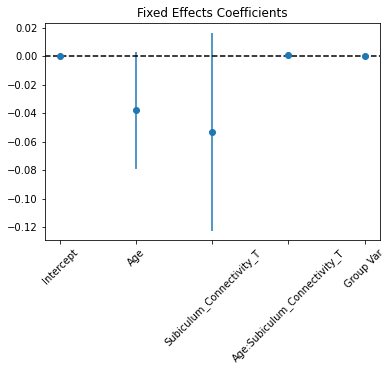

ValueError: Cannot predict random effects from singular covariance structure.

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'result' is the output from your mixedlm fit
model_result = result  # Use your model fit result

# 1. Fixed Effects Coefficients Plot
fe_params = model_result.params
conf_int = model_result.conf_int()
errors = conf_int[1] - fe_params

plt.errorbar(fe_params.index, fe_params, yerr=errors, fmt='o')
plt.axhline(0, color='black', linestyle='--')
plt.title('Fixed Effects Coefficients')
plt.xticks(rotation=45)
plt.show()

# 2. Random Effects Plot
# This example assumes one random intercept per group
re_params = pd.DataFrame([dict(re) for re in model_result.random_effects.values()])
re_params['group'] = model_result.random_effects.keys()

sns.stripplot(x='group', y='Intercept', data=re_params)
plt.title('Random Intercepts per Group')
plt.xticks(rotation=45)
plt.show()


# Backup to Pingouin
- Works best for ANOVA

In [225]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Age_Group', 'Age_And_Disease',
       'Age_Disease_and_Cohort', 'Subiculum_Group_By_Z_Score_Sign',
       'Subiculum_Group_By_Infl

In [241]:
data_df['test'].isna().sum()

0

In [233]:
import pingouin as pg

pg.mixed_anova(data=data_df, dv='Z_Scored_Percent_Cognitive_Improvement', between='Age_Disease_and_Cohort', within='Subiculum_Group_By_Inflection_Point', subject='test')

ValueError: cannot convert float NaN to integer